In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# import keras_tuner

from functools import partial

print("Keras Version:", keras.__version__)

2023-01-04 10:31:10.874150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Keras Version: 2.4.0


# Load Dataset for Demo

In [2]:
# Load fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Split the full training set into validation and actual training
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Modeling Streamline

## Preprocessing Layers

## Sequential Model

Sequential Model: Stack of dense layers

In [3]:
# Create a Sequential Model

# Create a template for dense layers using Python functools.partial
myDense = partial(keras.layers.Dense, 
                  activation="elu", 
                  kernel_initializer="he_normal", 
                  kernel_regularizer=keras.regularizers.l2(0.001)
                 )

# Create a sequential model structure
seq_model = keras.models.Sequential(layers=[keras.layers.Flatten(input_shape=[28,28],name="Flatten"), 
                                           keras.layers.BatchNormalization(),
                                           myDense(300),
                                           keras.layers.BatchNormalization(),
                                           myDense(100),
                                           keras.layers.BatchNormalization(),
                                           keras.layers.Dropout(rate=0.1),
                                           myDense(10, activation="softmax", kernel_initializer="glorot_uniform"),
                                          ]
                                  )

# Add layers after model structure creation
seq_model.add(myDense(50, activation="sigmoid", name="added_sigmoid"))

# Drop the last layer
seq_model.pop()

# Show model summary
print(seq_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

2023-01-04 10:31:12.881743: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-04 10:31:12.882479: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-04 10:31:12.909559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:31:12.909839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 208.91GiB/s
2023-01-04 10:31:12.909854: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-04 10:31:12.911748: I tensorflow/stream_executor/platform/def

## Non-Sequential Model Structure (Functional API)

In [4]:
# Create a graph of layers using functional API

# Create a template for dense layers using Python functools.partial
myDense = partial(keras.layers.Dense, 
                  activation="elu", 
                  kernel_initializer="he_normal", 
                  kernel_regularizer=keras.regularizers.l2(0.001)
                 )

# Create the model layers
input_layer = keras.layers.Input(shape=[28,28])
flatten_layer = keras.layers.Flatten()(input_layer)
layer1 = myDense(300)(flatten_layer)
layer2 = myDense(100)(layer1)
layer3 = myDense(200)(layer2)
layer4 = myDense(100)(layer1)
concat_layer = keras.layers.Concatenate()([layer3, layer4])
output_layer = myDense(10, activation="softmax", kernel_initializer="glorot_uniform")(concat_layer)

func_model = keras.Model(inputs=[input_layer,], outputs=[output_layer])

func_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300)          235500      flatten[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          30100       dense_3[0][0]                    
______________________________________________________________________________________________

## Obtain Parameters of Layers

In [5]:
# Show model layers
seq_model.layers

In [6]:
# Select Layer
print(seq_model.layers[3].name)
print(seq_model.get_layer("dense_1") is seq_model.layers[4])

batch_normalization_1
True


In [7]:
# Weights and Biases for each layer

weights, biases = seq_model.get_layer("dense_1").get_weights()

print(weights.shape)
print(biases.shape)

(300, 100)
(100,)


## Compile & Train Model

### Setup Tensorboard (Optional)

In [8]:
# Define directory structure to save log

import os
root_logdir = os.path.join(os.curdir, "log/fashion_mnist_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)

./log/fashion_mnist_logs/run_2023_01_04-10_31_13


In [9]:
# View TensorBoard
# Use % load_ext tensorboard if load on the first time
# Use %reload_ext tensorboard if already loaded before
%load_ext tensorboard 
%tensorboard --logdir ./log --port=8766

### Compile & Train

In [10]:
# Compile model and define loss, optimizer, and metrics
seq_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=keras.optimizers.Nadam(),
                  metrics=["accuracy"]
                 )

# Define callbacks

# Save best model for each epoch as a checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint("data/fashion_checkpoint.h5", save_best_only=True)
# Apply an early stopping rule
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#Tensorboard
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

# Train model
seq_history = seq_model.fit(X_train, y_train, epochs=100, 
                            validation_data=(X_valid, y_valid, None), #the 3rd item is sample weight on validation data
                            callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
                            # validation_split = 0.1 #if the dataset was not splitted
                            # sample_weight=, # weights on instances, supersedes class_weight
                            # class_weight=, # weights on target classes
                           )

2023-01-04 10:31:17.218311: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-04 10:31:17.218337: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-04 10:31:17.218361: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-01-04 10:31:17.218983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2023-01-04 10:31:17.339099: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-04 10:31:17.339251: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-04 10:31:17.608034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-04 10:31:17.628543: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3299150000 Hz


Epoch 1/100
   1/1719 [..............................] - ETA: 33:48 - loss: 4.0656 - accuracy: 0.0938

2023-01-04 10:31:18.684492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-04 10:31:18.822932: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


  45/1719 [..............................] - ETA: 21s - loss: 2.1113 - accuracy: 0.5934

2023-01-04 10:31:18.857912: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-04 10:31:18.857938: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-04 10:31:19.024041: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-04 10:31:19.024582: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-04 10:31:19.171195: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 439 callback api events and 427 activity events. 
2023-01-04 10:31:19.184677: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-04 10:31:19.194475: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./log/fashion_mnist_logs/run_2023_01_04-10_31_13/train/plugins/profile/2023_01_04_10_31_19
2023-01-04 10:31:19.202604: I tensorflow/core/profiler/rpc/cl

1719/1719 [==============================] - 8s 4ms/step - loss: 1.1988 - accuracy: 0.7918 - val_loss: 0.5998 - val_accuracy: 0.8590
Epoch 2/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6176 - accuracy: 0.8417 - val_loss: 0.5171 - val_accuracy: 0.8576
Epoch 3/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5401 - accuracy: 0.8482 - val_loss: 0.4940 - val_accuracy: 0.8628
Epoch 4/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5141 - accuracy: 0.8561 - val_loss: 0.4829 - val_accuracy: 0.8684
Epoch 5/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4984 - accuracy: 0.8583 - val_loss: 0.4479 - val_accuracy: 0.8766
Epoch 6/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4838 - accuracy: 0.8631 - val_loss: 0.4324 - val_accuracy: 0.8802
Epoch 7/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4587 - accuracy: 0.8696 - val_loss: 0.4475 - val_accuracy: 0.87

## Hyperparameter Tuning using Keras Tuner

## Evaluation & Prediction

In [11]:
# Attributes of history objects
print(seq_history.params)
print()
print(seq_history.epoch)
print()
# seq_history.history

{'verbose': 1, 'epochs': 100, 'steps': 1719}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]



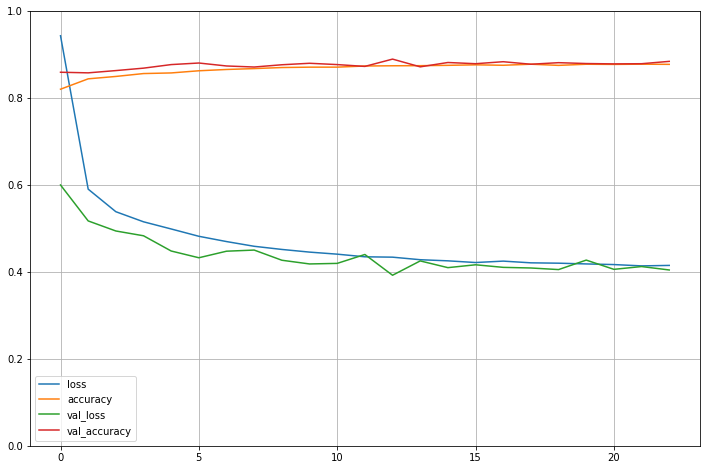

In [12]:
# Visualize the training history
pd.DataFrame(seq_history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
# Evaluate on test datasets
seq_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 36.6559 - accuracy: 0.7868


[36.655948638916016, 0.7868000268936157]

In [14]:
X_new = X_test[:3]

# Predicted proability
y_proba = seq_model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)
print(np.array(CLASS_NAMES)[y_pred])

y_new = y_test[:3]
print(y_new)

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']
[9 2 1]


# API Topics

## Dense Layer
- https://keras.io/api/layers/core_layers/dense/
- Dense Layers do multiplications only along the last axis of the input data.
    - Example, input shape (batch_size, d0, d1), kernel shape (d1, units). The layer will apply the multiplication between each sub-tensor of shape (1,1,d1) with the kernel. The output tensor is of shape (batch_size, d0, units).
    - Effectively, it treats sub-tensors along all axis other than the last independently. For example, for image pixels, rows (or columns) will be treated as independent.
    - If correlations among all dimensions are needed, then data must be flattened before input into a dense layer.

## Activation functions
- See https://keras.io/api/layers/activations/
    - "relu" or keras.activations.relu
    - "sigmoid" or keras.activations.sigmoid
    - "softmax" or keras.activations.relu
    - "softplus" or keras.activations.softplus
    - "softsign" or keras.activations.softsign
    - "tanh" or keras.activations.tanh
    - "selu" or keras.activations.selu
    - "elu" or keras.activations.elu
    - "exponential" or keras.activations.exponential

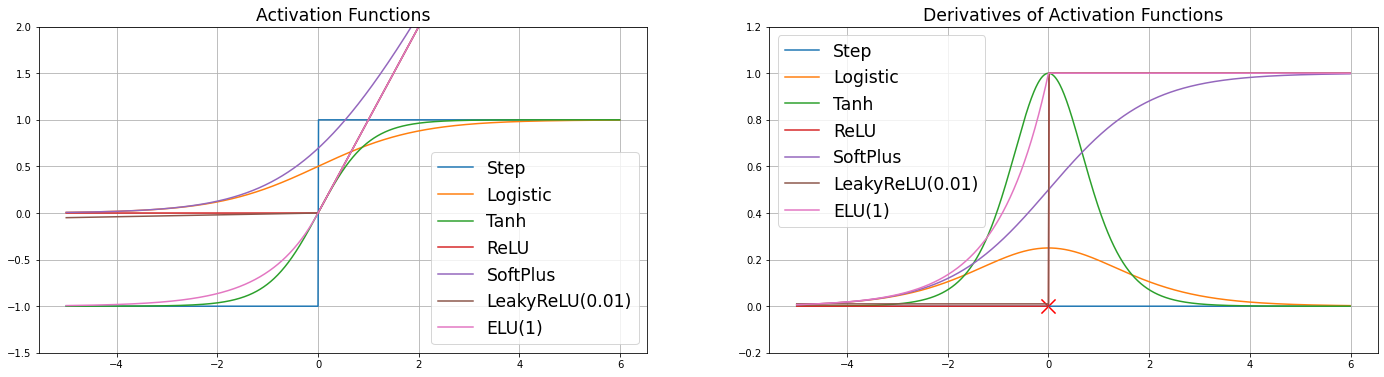

In [2]:
# Activation function visualization

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

x_s = np.arange(-5,6,0.01)

y_step = np.where(x_s>=0, 1,-1)
y_logistic = 1/(1+np.exp(-x_s))
y_tanh = 2/(1+np.exp(-2*x_s))-1
y_relu = np.where(x_s>=0,x_s,0)
y_softplus = np.log(1+np.exp(x_s))
y_leakyReLU = np.where(x_s>=0,x_s,0.01*x_s)
y_ELU = np.where(x_s>=0,x_s,1*(np.exp(x_s)-1))

dy_step = np.repeat(0,x_s.shape[0])
dy_logistic = np.exp(-x_s)/(1+np.exp(-x_s))**2
dy_tanh = 4*np.exp(-2*x_s)/(1+np.exp(-2*x_s))**2
dy_relu = np.where(x_s>=0,1,0)
dy_softplus = 1/(1+1/np.exp(x_s))
dy_leakyReLU = np.where(x_s>=0,1,0.01)
dy_ELU = np.where(x_s>=0,1,np.exp(x_s))

fig = plt.figure(figsize=[24,6])

ax1 = fig.add_subplot(1,2,1)

line11 = ax1.plot(x_s, y_step, label="Step")
line12 = ax1.plot(x_s, y_logistic, label="Logistic")
line13 = ax1.plot(x_s, y_tanh, label="Tanh")
line14 = ax1.plot(x_s, y_relu, label="ReLU")
line15 = ax1.plot(x_s, y_softplus, label="SoftPlus")
line16 = ax1.plot(x_s, y_leakyReLU, label="LeakyReLU(0.01)")
line17 = ax1.plot(x_s, y_ELU, label="ELU(1)")

ax1.set_ylim(-1.5,2)
ax1.legend(loc="lower right", fontsize="xx-large")
ax1.grid(True)
ax1.set_title("Activation Functions", fontsize="xx-large")

ax2 = fig.add_subplot(1,2,2)

line21 = ax2.plot(x_s, dy_step, label="Step")
line22 = ax2.plot(x_s, dy_logistic, label="Logistic")
line23 = ax2.plot(x_s, dy_tanh, label="Tanh")
line24 = ax2.plot(x_s, dy_relu, label="ReLU")
line25 = ax2.plot(x_s, dy_softplus, label="SoftPlus")
line26 = ax2.plot(x_s, dy_leakyReLU, label="LeakyReLU(0.01)")
line27 = ax2.plot(x_s, dy_ELU, label="ELU(1)")

ax2.scatter(0,0,marker='x',s=200, c='red')

ax2.set_ylim(-0.2,1.2)
ax2.legend(loc="upper left", fontsize="xx-large")
ax2.grid(True)
ax2.set_title("Derivatives of Activation Functions", fontsize="xx-large")

plt.show()

## Initializers
- Initializers are used to intialize the weights & bias for each layer
- Parameters: `kernel_initializer` (weight) and `bias_initializer`
- See https://keras.io/api/layers/initializers/

In [16]:
# Visualize He Normal and He Uniform initializers

model = keras.models.Sequential(layers=[keras.Input(shape=(600,500)),
                                        keras.layers.Dense(units=2000,
                                                           activation="elu",
                                                           kernel_initializer=keras.initializers.HeNormal(),
                                                          ),
                                        keras.layers.Dense(units=2000,
                                                           activation="elu",
                                                           kernel_initializer=keras.initializers.HeUniform(),
                                                          ),
                                       ],
                                name=["norm_init","unif_init"]
                               )

norm_weight, norm_bias = model.layers[0].get_weights()
unif_weight, unif_bias = model.layers[1].get_weights()

print(norm_weight.shape)
print(norm_bias.shape)

print(unif_weight.shape)
print(unif_bias.shape)

model.summary()

(500, 2000)
(2000,)
(2000, 2000)
(2000,)
Model: "['norm_init', 'unif_init']"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 600, 2000)         1002000   
_________________________________________________________________
dense_9 (Dense)              (None, 600, 2000)         4002000   
Total params: 5,004,000
Trainable params: 5,004,000
Non-trainable params: 0
_________________________________________________________________


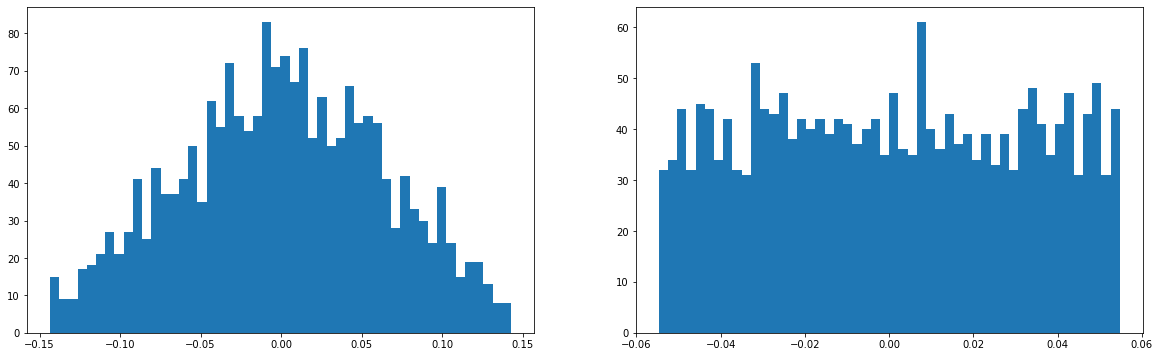

In [19]:
# Visualize He Normal and He Uniform initializers
fig = plt.figure(figsize=[20,6])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(norm_weight[23],bins=50)
ax2.hist(unif_weight[15],bins=50)
plt.show()

## Loss Functions
- `loss="binary_crossentropy"` or `loss=keras.losses.BinaryCrossentropy`
    - binary-class, single-lable classification target with 2 classes
- `loss="sparse_categorical_crossentropy"` or `loss=keras.losses.SparseCategoricalCrossentropy`
    - multi-class, single-label (classes are exclusive) classification target with more than 2 classes
    - The targets are NOT one-hot encoded.
    - Example of a target for one instance: 4
- `loss="categorical_crossentropy"` or `loss=keras.losses.CategoricalCrossentropy`
    - multi-class, single-label (classes are exclusive) classification target with more than 2 classes
    - The targets are one-hot encoded.
    - Example of a target for one instance: [0.,0.,1.,0.]
- Multi-class, multi-label????
- Regression???

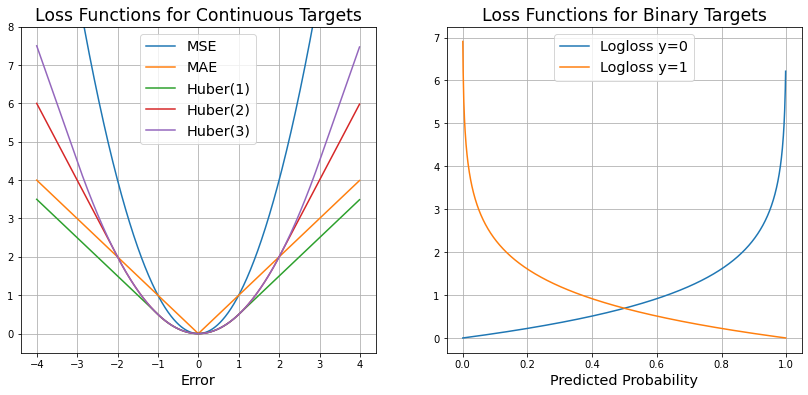

In [3]:
# Loss Function Visualization

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

e_s = np.arange(-4,4,0.01)
y_mse = e_s**2
y_mae = np.absolute(e_s)

fig = plt.figure(figsize=[14,6])
ax1 = fig.add_subplot(1,2,1)

line1 = ax1.plot(e_s,y_mse,label="MSE")
line2 = ax1.plot(e_s,y_mae,label="MAE")

for i in [1,2,3]:
    ax1.plot(e_s,np.where(np.absolute(e_s)<=i,0.5*e_s**2,i*(np.absolute(e_s)-0.5*i)), label=f"Huber({i})")

ax1.set_ylim(-0.5,8)
ax1.grid(True)
ax1.legend(fontsize="x-large")
ax1.set_title("Loss Functions for Continuous Targets", fontsize="xx-large")
ax1.set_xlabel("Error", fontsize="x-large")
# plt.gca().set_aspect('equal', adjustable='box')

p_s = np.arange(0.001,0.999,0.001)
log_y0 = -np.log(1-p_s)
log_y1 = -np.log(p_s)

ax2 = fig.add_subplot(1,2,2)

line3 = ax2.plot(p_s,log_y0,label="Logloss y=0")
line4 = ax2.plot(p_s,log_y1,label="Logloss y=1")

ax2.grid(True)
ax2.legend(fontsize="x-large",loc="upper center")
ax2.set_title("Loss Functions for Binary Targets", fontsize="xx-large")
ax2.set_xlabel("Predicted Probability", fontsize="x-large")

plt.show()

## Data Processing
- `keras.utils.to_categrical()` to convert sparse labels to one-hot vector labels

## Regularizers
- Penalties are computed and then summed into the loss function 

### Kernel (Weight) Regularizers